## Task 4) Evaluation


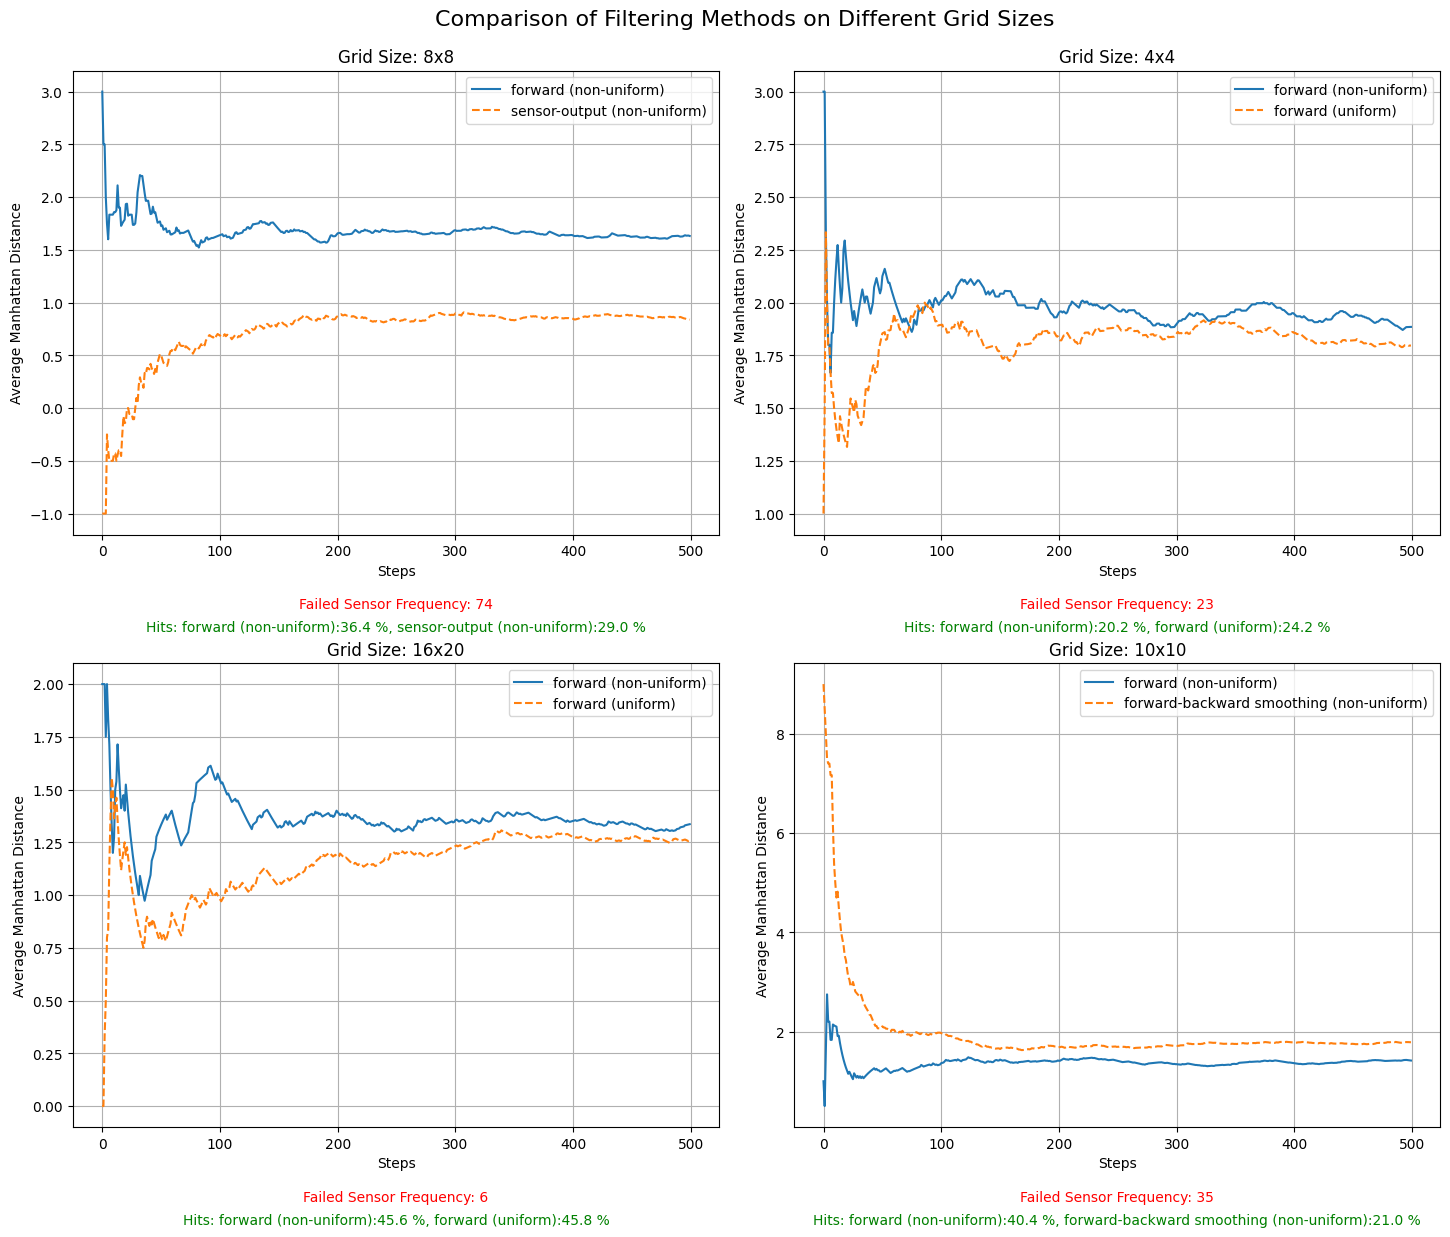

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import Filters
from models import *

class Localizer:
    def __init__(self, sm, failure1, filter1, skip_steps1, failure2, filter2, skip_steps2):
        self.__sm = sm
        self.__skip_steps1 = skip_steps1
        self.__skip_steps2 = skip_steps2

        self.__tm = TransitionModel(self.__sm)
        if failure1 == 'uniform':
            self.__om1 = ObservationModel_UF.ObservationModelUF(self.__sm)
        else:
            self.__om1 = ObservationModel_NUF.ObservationModel(self.__sm)
        if failure2 == 'uniform':
            self.__om2 = ObservationModel_UF.ObservationModelUF(self.__sm)
        else:
            self.__om2 = ObservationModel_NUF.ObservationModel(self.__sm)

        self.__filter_type1 = filter1
        self.__filter_type2 = filter2
        
        self.initialise()

    # retrieve the transition model that we are currently working with
    def get_transition_model(self) -> np.array:
        return self.__tm

    # retrieve the observation model that we are currently working with
    def get_observation_model(self) -> np.array:
        return self.__om

    # the current true pose (x, h, h) that should be kept in the local variable __trueState
    def get_current_true_pose(self) -> (int, int, int):
        x, y, h = self.__sm.state_to_pose(self.__trueState)
        return x, y, h

    # the current probability distribution over all states
    def get_current_f_vector(self) -> np.array(float):
        return self.__probs

    # the current sensor reading (as position in the grid). "Nothing" is expressed as None
    def get_current_reading(self) -> (int, int):
        ret = None
        if self.__sense != None:
            ret = self.__sm.reading_to_position(self.__sense)
        return ret;

    # get the currently most likely position, based on single most probable pose
    def most_likely_position(self) -> (int, int):
        return self.__estimate

    # (re-)initialise for a new run without change of size
    def initialise(self):
        self.__trueState = random.randint(0, self.__sm.get_num_of_states() - 1)
        self.__sense1 = None
        self.__sense2 = None
        self.__probs1 = np.ones(self.__sm.get_num_of_states()) / (self.__sm.get_num_of_states())
        self.__probs2 = np.ones(self.__sm.get_num_of_states()) / (self.__sm.get_num_of_states())
        self.__estimate1 = self.__sm.state_to_position(np.argmax(self.__probs1))
        self.__estimate2 = self.__sm.state_to_position(np.argmax(self.__probs2))

        # simple evaluation measures that go into the visualisation, add more if you like!

        self.__rs = RobotSim( self.__trueState, self.__sm)
        self.__HMM1 = Filters.HMMFilter( self.__probs1, self.__tm, self.__om1, self.__sm)
        self.__HMM2 = Filters.HMMFilter( self.__probs2, self.__tm, self.__om2, self.__sm)
        self.__HMM_smooth1 = Filters.HMMSmoother(self.__HMM1)
        self.__HMM_smooth2 = Filters.HMMSmoother(self.__HMM2)
        self.__HMM_forward_backward1 = Filters.HMMForwardBackward(self.__HMM1, self.__HMM_smooth1)
        self.__HMM_forward_backward2 = Filters.HMMForwardBackward(self.__HMM2, self.__HMM_smooth2)

        # Keep track of last 5 sensor readings
        self.sensor_history1 = []
        self.sensor_history2 = []
    #
    #  The update cycle:
    #  - robot moves one step, generates new state / pose
    #  - sensor produces one reading based on the true state / pose
    #  - filtering approach produces new probability distribution based on
    #  sensor reading, transition and sensor models
    #
    #  Reports back to the caller (viewer):
    #  Return
    #  - true if sensor reading was not "nothing", else false,
    #  - AND the three values for the (new) true pose (x, y, h),
    #  - AND the two values for the (current) sensor reading (if not "nothing")
    #  - AND the two errors made in this step for each filter
    #  - AND the two new probability distributions for each filter
    def update(self) -> (bool, int, int, int, int, int, int, int, int, int, np.array(1), np.array(1)) :
        # Move robot and get sensor reading
        self.__trueState = self.__rs.move_once(self.__tm)

        if self.__om1 == self.__om2:
            self.__sense1 = self.__rs.sense_in_current_state(self.__om1)
            self.__sense2 = self.__sense1
        else:
            self.__sense1 = self.__rs.sense_in_current_state(self.__om1)
            self.__sense2 = self.__rs.sense_in_current_state(self.__om2)

        if self.__filter_type1 == 'forward-backward smoothing':
            # Update sensor history
            self.sensor_history1.append(self.__sense1)
            if len(self.sensor_history1) > 5:
                self.sensor_history1.pop(0)
                self.__probs1 = self.__HMM_forward_backward1.forward_backward(self.sensor_history1)[-1]
        elif self.__filter_type1 == 'forward':
            self.__probs1 = self.__HMM1.filter(self.__sense1)
        elif self.__filter_type1 == 'sensor-output':
            self.__probs1 = self.__HMM1.filter(self.__sense1)

        fPositions1 = self.__probs1.copy()

        for state in range(0, self.__sm.get_num_of_states(), 4) :
            fPositions1[state:state+4] = sum(fPositions1[state:state+4])

        self.__estimate1 = self.__sm.state_to_position(np.argmax(fPositions1))

        if self.__filter_type2 == 'forward-backward smoothing':
            # Update sensor history
            self.sensor_history2.append(self.__sense2)
            if len(self.sensor_history2) > 5:
                self.sensor_history2.pop(0)
                self.__probs2 = self.__HMM_forward_backward2.forward_backward(self.sensor_history2)[-1]
        elif self.__filter_type2 == 'forward':
            self.__probs2 = self.__HMM2.filter(self.__sense2)
        elif self.__filter_type2 == 'sensor-output':
            self.__probs2 = self.__HMM2.filter(self.__sense2)

        fPositions2 = self.__probs2.copy()

        for state in range(0, self.__sm.get_num_of_states(), 4) :
            fPositions2[state:state+4] = sum(fPositions2[state:state+4])

        self.__estimate2 = self.__sm.state_to_position(np.argmax(fPositions2))

        ret = False  # in case the sensor reading is "nothing" this is kept...
        tsX, tsY, tsH = self.__sm.state_to_pose(self.__trueState)
        srX = -1
        srY = -1
        if self.__sense1 != None:
            srX, srY = self.__sm.reading_to_position(self.__sense1)
            ret = True

        if self.__sense2 != None:
            srX, srY = self.__sm.reading_to_position(self.__sense2)
            ret = True

        eX1, eY1 = self.__estimate1
        eX2, eY2 = self.__estimate2

        # calculate error (skip if sensor reading is "nothing" and skip_steps is True)
        if self.__skip_steps1 and self.__sense1 is None:
            error1 = -1
        else:
            error1 = abs(tsX-eX1)+abs(tsY-eY1)

        if self.__skip_steps2 and self.__sense2 is None:
            error2 = -1
        else:
            error2 = abs(tsX-eX2)+abs(tsY-eY2)


        return ret, tsX, tsY, tsH, srX, srY, eX1, eY1, error1, eX2, eY2, error2, fPositions1, fPositions2

# Manhattan distance = |X1 – X2| + |Y1 – Y2|
# the error returned by the localizer is the Manhattan distance between the true position and the estimated position
# if -1 is returned, it means that the sensor reading was "nothing" and the step was skipped

def run_simulation(steps, row, column, filter1, failure1, filter2, failure2, skip_steps1, skip_steps2):
    state_model = StateModel(row,column)

    localizer_filter = Localizer(state_model, failure1, filter1, skip_steps1, failure2, filter2, skip_steps2)

    cumulative_errors_filter1 = 0.0
    cumulative_errors_filter2 = 0.0
    valid_steps1 = 0
    valid_steps2 = 0
    sensor_failures = 0
    avg_errors_filter1 = []
    avg_errors_filter2 = []
    hits_filter1 = 0
    hits_filter2 = 0

    for i in range(steps):
        has_reading, _, _, _, _, _, _, _, error_filter1, _, _, error_filter2, _, _ = localizer_filter.update()

        # Count hits
        if error_filter1 == 0:
            hits_filter1 += 1
        if error_filter2 == 0:
            hits_filter2 += 1

        # Check and count sensor reading which were "nothing" and skip those steps
        if not has_reading:
            sensor_failures += 1
            avg_errors_filter1.append(cumulative_errors_filter1 / valid_steps1 if valid_steps1 > 0 else 0)
            avg_errors_filter2.append(cumulative_errors_filter2 / valid_steps2 if valid_steps2 > 0 else 0)
        else:
            cumulative_errors_filter1 += error_filter1
            valid_steps1 += 1
            avg_errors_filter1.append(cumulative_errors_filter1 / valid_steps1)
            cumulative_errors_filter2 += error_filter2
            valid_steps2 += 1
            avg_errors_filter2.append(cumulative_errors_filter2 / valid_steps2)

    return avg_errors_filter1, avg_errors_filter2, sensor_failures, hits_filter1, hits_filter2


def plot_comparisons():
    setups = [
        ((8,8), 'forward', 'non-uniform', 'sensor-output', 'non-uniform', False, True),
        ((4,4), 'forward', 'non-uniform', 'forward', 'uniform', False, False),
        ((16,20), 'forward', 'non-uniform', 'forward', 'uniform', False, False),
        ((10,10), 'forward', 'non-uniform', 'forward-backward smoothing', 'non-uniform', False, False)
    ]

    steps = 500
    # Create figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    axs = axs.ravel()

    # Process each setup pair
    for idx in range(0, len(setups), 1):
        setup = setups[idx]
        grid_size, filter_1, failure_1, filter_2, failure_2, skip_steps1, skip_steps2 = setup
        
        # Run simulation and get errors
        avg_errors_1, avg_errors_2, failed_sensor, hits_filter1, hits_filter2 = run_simulation(steps, grid_size[0], grid_size[1],
                                          filter_1, failure_1, filter_2, failure_2, skip_steps1, skip_steps2)

        # Create x-axis with actual steps
        steps_axis = np.arange(steps)

        # Create subplot
        ax = axs[idx]
        
        # Plot both methods
        label1 = f"{filter_1} ({failure_1})"
        label2 = f"{filter_2} ({failure_2})"
        ax.plot(steps_axis, avg_errors_1, label=label1)
        ax.plot(steps_axis, avg_errors_2, label=label2, linestyle='--')
        
        # Customize subplot
        ax.set_xlabel('Steps')
        ax.set_ylabel('Average Manhattan Distance')
        ax.set_title(f'Grid Size: {grid_size[0]}x{grid_size[1]}')
        ax.grid(True)
        ax.legend()

        failed_sensors_text = f"Failed Sensor Frequency: {failed_sensor}"
        ax.text(0.5, -0.15, failed_sensors_text, ha='center', va='center', transform=ax.transAxes, fontsize=10, color='red')

        hits_text = f"Hits: {label1}:{np.round(hits_filter1/steps *100,2)} %, {label2}:{np.round(hits_filter2/steps *100,2)} %"
        ax.text(0.5, -0.2, hits_text, ha='center', va='center', transform=ax.transAxes, fontsize=10, color='green')

    # Adjust layout
    plt.tight_layout()
    fig.suptitle('Comparison of Filtering Methods on Different Grid Sizes', y=1.02, fontsize=16)
    plt.show()

# Run the evaluation plots
plot_comparisons()